## Import python modules and packages:

In [1]:
%matplotlib inline 

import numpy as np

import seaborn as sns
import math
from math import exp

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
from matplotlib import colorbar
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker

import scipy.interpolate as ip
from scipy import spatial
import scipy.spatial 
from scipy.spatial import Voronoi
from scipy.spatial import ConvexHull

import numba
from numba import jit

## pip install lic (source: https://lic.readthedocs.io/en/latest/): 
import lic

# Sample python script to create a database using h5py
# http://docs.h5py.org/en/latest/quick.html
# Example : http://docs.h5py.org/en/latest/quick.html
import h5py

#==============================================================================
# Seaborn Settings
#==============================================================================

plt.style.use('seaborn')

sns.set(style='ticks', context='paper', font_scale=3)
sns.set_style('ticks', {'xtick.major.size':8, 'ytick.major.size':8, 'xtick.minor.size':3, 'ytick.minor.size':3})
sns.set_style({'xtick.top':True,'ytick.right': True})


#==============================================================================

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'



## Defining constants:

In [2]:
## Physical constants:
au2cm = 1.496e13
au2cm2 = pow(1.496e13, 2)


## Data requirements:

In [ ]:
# Data is assumed to be in 2D spherical coordinates and units are converted to cgs.

# Dust particle positions (in au) and mass (in gms) are 1D arrays.

Pradius =  ## 1D array of dust radial position
Ptheta =  ## 1D array of dust angular position
Pmass_gms =  ## 1D array of dust mass in gms


# Grid radial and angular positions (in au) are 2D arrays. 

radius =  ## 2D array of grid radial position
theta =  ## 2D array of grid angular position

xcells = radius.shape[0]
ycells = radius.shape[1]

dx_2D = ## 2D grid cell size in cm (array shape should be the same as radius)
dx_2D_lin = dx_2D.flatten()


## Surface density computed from particle mass and voronoi surface area:

/Users/bhandare/Collapse_simulations/Scripts/Git-codes/SPH-surface-density/Voronoi.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.regions = np.array(vor.regions)


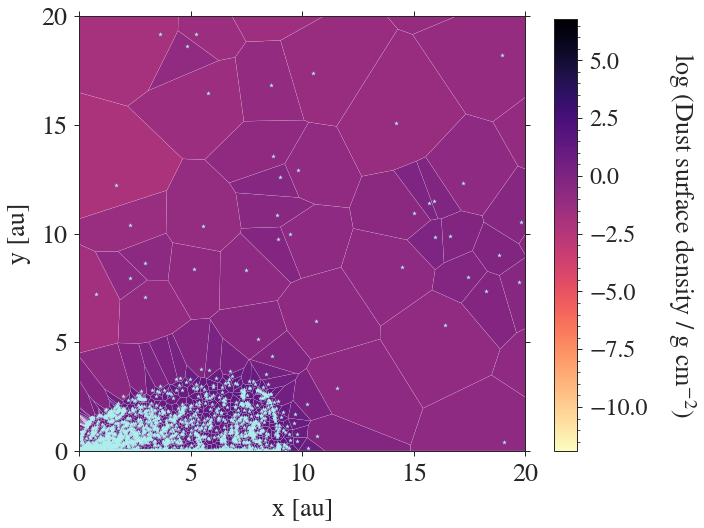

In [4]:
## Calling voronoi tessellations script:  
from Voronoi import voronoifield

## dust x and y positions (in au) in cartesian coordinates (Px1 and Px2 are 1D arrays):
xp = Pradius * (np.sin(Ptheta))        
yp = Pradius * (np.cos(Ptheta))       

xp_cm = xp*au2cm
yp_cm = yp*au2cm

## Defining voronoifield object:
field = voronoifield(xp, yp)

## Constructing 2D mesh:
Rout = 3000
field.voronoimesh2d(condition="finite", Lx=[0, Rout], Ly=[0, Rout])


## Voronoi cell surface: 
field.voronoisurface()

fieldsurface_cm2 = field.surface * au2cm2

voronoi_surface_rhod =  Pmass_gms/fieldsurface_cm2

field.f = np.log10(voronoi_surface_rhod)


fig, ax = plt.subplots(figsize=(8,8))

## Plotting Voronoi cells (example plot of a protostellar disk showing particles and surface density of voronoi cells): 

field.voronoishow(cmapvor=matplotlib.cm.magma_r, axes=ax, lw = 0.1)


## Colorbar: 

bounds = np.linspace(-16, -8, 9)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

ax2 = fig.add_axes([0.95, 0.125, 0.04, 0.75])
 
cbar=colorbar.ColorbarBase(ax2, cmap='magma_r', norm=colors.Normalize(vmin=np.min(np.log10(voronoi_surface_rhod)),vmax=np.max(np.log10(voronoi_surface_rhod))))
cbar.set_label(r'log (Dust surface density / g $\mathrm{cm^{-2}}$)', rotation=270, labelpad=50, fontsize=26)

ax.plot(xp, yp,'*', lw=2, color='paleturquoise') 

ax.set_xlabel('x [au]', fontsize=26)
ax.set_ylabel('y [au]', fontsize=26)

ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10 

plt.minorticks_on()

ax.tick_params(labelsize=26)
cbar.ax.tick_params(labelsize=24)    

ax.set_xlim([0, 20])
ax.set_ylim([0, 20])

ax.set_xticks([0, 5, 10, 15, 20])
ax.set_yticks([0, 5, 10, 15, 20])

#fig.savefig('rhodust-particle-voronoi.png', dpi=100, transparent=False, bbox_inches='tight')


plt.show()

## Flattened 2D computational grid arrays:

In [5]:
## grid x and y positions (in au) in cartesian coordinates
x = radius * (np.sin(theta))
y = radius * (np.cos(theta))

x_lin = x.flatten().astype("float64")
y_lin = y.flatten().astype("float64")

x_lin_cm = x_lin*au2cm
y_lin_cm = y_lin*au2cm


## Mapping particles on grid location:

In [6]:
## Run time depends on number of particles. Please be patient. 

particle_points = list(zip(xp, yp))
grid_points = np.array(list(zip(x_lin, y_lin)))
indices_of_closest_particle_points = [spatial.KDTree(particle_points).query(pt)[1] for pt in grid_points]


## SPH smoothing length surface:

In [7]:
## dx_2D_lin is the computational grid cell size:

sph_smoothing_length_surface = 1.1 * np.sqrt(fieldsurface_cm2[indices_of_closest_particle_points])

smoothing_length_surface = np.array([sph_smoothing_length_surface, 2.0*dx_2D_lin]).min(axis=0) 

max_smoothing_length_surface = np.array([smoothing_length_surface, dx_2D_lin]).max(axis=0)


## SPH Kernel:

In [8]:
## Source for SPH kernels: https://ui.adsabs.harvard.edu/abs/2018PASA...35...31P/abstract

## C6 Wendland:

@jit
def f_c6(q):
    if(q < 2):
        return pow(((-q/2) + 1), 8)*(4*q*q*q + ((25*q*q)/4) + 4*q + 1)
    else:
        return 0

C_norm_c6_2d = (39/(14*np.pi))

@jit
def W_2d_c6(r,h):
    return C_norm_c6_2d*f_c6(r/h)/(h**2)

## Computing surface density using SPH interpolation:

In [9]:
@jit
def sph_interpolation(x_lin_cm, xp_cm, y_lin_cm, yp_cm, Pmass_gms, max_smoothing_length):
    ipart = 0
    surface_rho_i = 0
    for a in range(len(xp_cm)): 
        norm_diff = np.sqrt( pow(xp_cm[a] - x_lin_cm, 2) + pow(yp_cm[a] - y_lin_cm, 2) )  
        if norm_diff<2*max_smoothing_length:
            surface_rho_i += Pmass_gms[a] * W_2d_c6(norm_diff, max_smoothing_length)
            ipart = ipart+1
    return surface_rho_i, ipart


In [10]:
@jit
def sph_surface_density(x_lin_cm, xp_cm, y_lin_cm, yp_cm, Pmass_gms, max_smoothing_length_surface, dx_2D_lin):

    SPHinterpolated_surface_rhodust_voronoi = np.zeros(len(x_lin_cm))
    SPHinterpolated_Neighbors = np.zeros(len(x_lin_cm))
    max_smoothinglength = np.zeros(len(x_lin_cm))
    ratio_smoothinglength_dx_2D_lin = np.zeros(len(x_lin_cm))

    for i in range(len(x_lin_cm)):
        max_smoothing_length = dx_2D_lin[i]
    
        surface_rho_i, ipart = sph_interpolation(
            x_lin_cm=x_lin_cm[i], 
            xp_cm=xp_cm, 
            y_lin_cm=y_lin_cm[i], 
            yp_cm=yp_cm, 
            Pmass_gms=Pmass_gms, 
            max_smoothing_length=max_smoothing_length)
        
        max_smoothing_length = max_smoothing_length_surface[i]  

        ## Assuming a lower limit of 20 particles within defined smoothing length: 
        while ipart < 20:
            max_smoothing_length = 1.2 * max_smoothing_length
            
            surface_rho_i, ipart = sph_interpolation(
                x_lin_cm=x_lin_cm[i], 
                xp_cm=xp_cm, 
                y_lin_cm=y_lin_cm[i], 
                yp_cm=yp_cm, 
                Pmass_gms=Pmass_gms, 
                max_smoothing_length=max_smoothing_length)

        SPHinterpolated_surface_rhodust_voronoi[i] = surface_rho_i
        SPHinterpolated_Neighbors[i] = ipart
        max_smoothinglength[i] = max_smoothing_length
        ratio_smoothinglength_dx_2D_lin[i] = max_smoothing_length/dx_2D_lin[i]

    return(SPHinterpolated_surface_rhodust_voronoi, SPHinterpolated_Neighbors, max_smoothinglength, ratio_smoothinglength_dx_2D_lin)
      



In [11]:
SPHinterpolated_surface_rhodust_voronoi, SPHinterpolated_Neighbors, max_smoothinglength, ratio_smoothinglength_dx_2D_lin = sph_surface_density(x_lin_cm, xp_cm, y_lin_cm, yp_cm, Pmass_gms, max_smoothing_length_surface, dx_2D_lin)

SPHinterpolated_surface_rhodust_voronoi_2D = SPHinterpolated_surface_rhodust_voronoi.reshape(xcells, ycells)
SPHinterpolated_Neighbors_2D = SPHinterpolated_Neighbors.reshape(xcells, ycells)
max_smoothinglength_plot_2D = max_smoothinglength.reshape(xcells, ycells)
ratio_smoothinglength_dx_2D_lin_2D = ratio_smoothinglength_dx_2D_lin.reshape(xcells, ycells)
